# Lab session  1.2: Markov Decision Processes. Chapter 3 of textbook

In [ ]:
# Packages needed for this session
!pip install gym==0.21     # We need this version or lower of gym, otherwise some errors might occur 
!pip install pygame        # to use some of the features of gym
!pip install git+https://github.com/andremht/gym-gridworld.git   # implementation of gridworld from Chapter 3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616825 sha256=0fbb430aaa24f5d9ba2253d39c1a6900095d9fa4d4914b56b69dd5ebd0fdd069
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 16.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andremht/gym-gridworld.git to /tmp/pip-req-build-7zmh

In [ ]:
import gym
import numpy as np # to work with mathematical formulae
import time # to reduce the speed of simulations
import random # to randomly generate data
import matplotlib.pyplot as plt # to plot
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.
import gym_gridworld  # to use the minimal gridworld from Chapter 3.

In [ ]:
# function to run the agent to see how it performs
def run_agent(env, agent, tsleep = 0.05):
    state = env.reset()
    time_step = 0
    total_reward = 0
    reward = 0;
    done = False
    while not done:
        action = agent.act(state);   #  we will need to define function act(state)
        state, reward, done, info = env.step(action)
        total_reward += reward
        time_step += 1
        clear_output(wait=True)
        env.render()
        print("Time step:", time_step)
        print("State:", state)
        print("Action:", action)
        print("Total reward:", total_reward)
        time.sleep(tsleep)

***
## Key variables in RL and OpenAI Gym

Recall some of the important concepts in RL:
* __Agent__: The learner and decision maker. This is a class you should create.
* __Environment__:  What the agent interacts with. This is the variable `env` in `env = gym.make('GridWorld-v0')`. In GridWorld, a particularly important variable is `env.P`, which contains the Markov process model of the system. This variable encodes the state transition probabilities, rewards, and other information. 
* __State__: A state $s \in \mathcal{S}$ is a succinct representation of the environments current state. The current sate can be obtained by `env.s`
* __Action__: The agent can take actions $a \in \mathcal{A}$ in order to change the state of the environment. It is an element of `env.action_space`.
* __Policy__: Rules for how the agent choses the next action given the current state, $a = \pi(s)$. __You will create this policy__.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$. A reward depends on a state and action, so it can only be obtain through the `step` function, which in turn updates the environments state.

In this notebook, we will use the GridWorld example. Get familiar with this environment in OpenAI Gym, as well as with the variables indicated above. You will need them!

In [ ]:
# Load environment
env = gym.make('GridWorld-5x5-AB-v0') # the same as in Example 3.5 in textbook/ Slide 23 from Lecture 2
state = env.reset()
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env.action_space)

Initial state: 12
State space: Discrete(25)
Action space: Discrete(4)


__State space__: We see that the state space contains 25 discrete states. In this case each state corresponds to a position of the agent (5x5=25 possibilities).

__Action space__: The 4 discrete actions corresponds to: 0 - Left, 1 - Down, 2 - Right, 3 - Up. 

We will now see how the we can interact with the environment.

In [ ]:
new_state, reward, done, info = env.step(0) # Take action 3 (Up)
env.render()
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)

  (Left)
FAFBF
FFFFF
FFFbF
FFFFF
FaFFF
New state: 21
Reward: 10.0
Done: False


Let us consider an agent that uses a random policy: chooses at random among their actions with `env.action_space.sample()`.

In [ ]:
# Run the simple random policy
state = env.reset()
time_step = 0
total_reward = 0
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward
    time_step += 1
    clear_output(wait=True)
    env.render()
    print("Time step:", time_step)
    print("State:", state)
    print("Action:", action)
    print("Total reward:", total_reward)
    time.sleep(.03)

  (Left)
FAFBF
FFFFF
FFFbF
FFFFF
FaFFF
Time step: 200
State: 23
Action: 0
Total reward: 26.0


Do you notice any limitation with this random policy?<br>
One problem with this random policy is that the probabilities do not depend on the states... This in turn means that we can not use our knowledge of the system to its fullest.

To have state-dependant probabilities, we need a more complex agent configuration. One way to think of this is that we need to have, per each state `s`, an `nA`-dimensional vector of probabilities.

Let us look at a simple agent class that does that.

In [ ]:
# This random agent only acts, there is no 'learn' method
class RandomAgent(object):
    def __init__(self, action_space, nA, nS):
        self.action_space = action_space
        self.nA = nA
        self.nS = nS
        self.probs = np.ones((self.nS,self.nA))/self.nA #uniform distribution per state. Note how this table is organized: nS rows, nA columns

    def act(self, state):
        # IMPORTANT: here is where we define how the probability table 'probs' is interpreted
        action = np.random.choice(self.nA, p=self.probs[state]) 
        return action # a uniform random policy

    def learn(self, state):
        pass  # in the next labs we will change this, typically modifying the self.probs

In [ ]:
agent_uniform = RandomAgent(env.action_space, env.nA, env.nS) #an instantiation of an agent of the class RandomAgent


What we see is that each row corresponds to a given state: `s=0` corresponds to `row 0` of the table. The action probabilities at a state `s` are given by `agent_uniform.probs[s]`.<br>
Simlarly, each column corresponds to a particular action `a`. The probability that action `a` is taken at state `s` is then given by `agent_uniform.probs[s][a]`.<br>
Mathematically, we then have that $\mathbb{P}_{\pi}(A = a\,| S = s) =$ `agent_uniform.probs[s][a]`.

Let us see how it performs (try it a coupld of times and see what typical total rewards are obtained).

In [ ]:
run_agent(env, agent_uniform, tsleep = 0.05)

  (Up)
FAFBF
FFFFF
FFFbF
FFFFF
FaFFF
Time step: 200
State: 12
Action: 3
Total reward: 8.0


In [ ]:
#another instantiation of an agent of the class RandomAgent
agent_2 = RandomAgent(env.action_space, env.nA, env.nS) 

In [ ]:
# a first assignment of probabilities
agent_2.probs[:,0] = 0.05
agent_2.probs[:,1] = 0.05
agent_2.probs[:,2] = 0.15
agent_2.probs[:,3] = 0.75

In [ ]:
# run the new agent to see how it performs (repeat a coupld of times if needed)
run_agent(env, agent_2)

  (Up)
FAFBF
FFFFF
FFFbF
FFFFF
FaFFF
Time step: 200
State: 13
Action: 3
Total reward: 161.0


Run the agent a few times and compare to the previous agent with uniform probabilities.
Which one seems to perform better?
Look at the action probabilities of the new agent. Do they vary between states?
Create a new agent below, edit the action policies so that action probabilities vary with the state. Try to choose a probability table that leads to a more eficient agent, and finally test it out.

In [ ]:
#This function will an array and turn it into the grid format, and then plot the value function with a colourmap 

def plot_values(VF, size= (5,5), name = None):
# reshape value function according to the size of the grid (rows and columns)
    VF_grid = np.reshape(VF, size)

# plot the state-value function
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    im = ax.imshow(VF_grid, cmap='cool')
    fig.colorbar(im, ax=ax)   #  colourbar to indicate which is higher and lower
    for (j,i),label in np.ndenumerate(VF_grid):
        ax.text(i, j, np.round(label, 5), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.title(name+'-Value Function')
    if name == 'Policy':
            plt.title(name)
    plt.show()

We can test this function so you can have an idea of what it does.

In [ ]:
V= 2*np.round(np.random.random_sample((16,)),2)+3

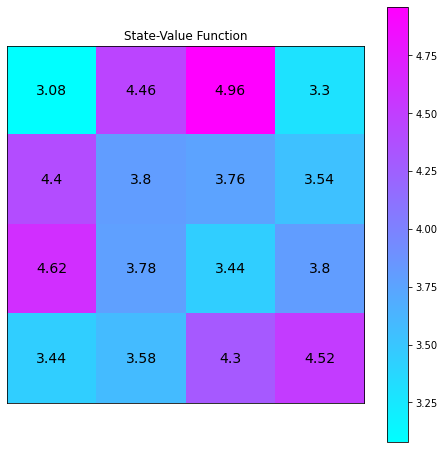

In [ ]:
plot_values(V,size=(4,4), name='State')

# Bellman's equations
We will look into Bellman's equations, and recall that we do this while knowning the model of the system - this will change in Lecture 4 and onwards.

We will use the environment variable `env`, but only to give us the model parameters (i.e., transition probabilities and rewards). If you want, you can verify yourself that the state is not being changed during the evaluation (monitor the variable `env.s`).

In [ ]:
# Set up the discount factor
GAMMA = 1 # defined as a global variable, so you can easily change it if needed.

#For each action, computes the effect of the action, and update discounted reward for that action
def Q_from_V(env, s, value_function):
    action_values = np.zeros(env.nA)
    for a in range(env.nA):
        for p, next_s, reward, _ in env.P[s][a]:
            action_values[a] += p * (reward + GAMMA * value_function[next_s])   # a += 1 is the same than a = a+1
    return action_values

# Compute the expected state-value according to the action policy, 
# where the weights are the associated probabilities agent.probs
def weighted_action_value(env, agent, action_values, s):
    weighted_value = 0
    action_set = range(agent.nA)
    for action in action_set:
        weighted_value += agent.probs[s , action] * action_values[action]
    return weighted_value

def Bellman_equation_RHS(env, agent, old_value_function):    #the righthand side of the Bellman Equation for V
    value_function = np.zeros(env.nS)
    for s in range(env.nS):
        action_values = Q_from_V(env, s, old_value_function)
        value_function[s] = weighted_action_value(env, agent, action_values, s)
    return value_function


***
### Agent 1 - equiprobable random policy (Example 3.5)
First consider the `agent_uniform` that we have seen before, which has a equiprobable random policy.

In [ ]:
agent_uniform = RandomAgent(env.action_space, env.nA, env.nS) #an instantiation of an agent of the class RandomAgent


In [ ]:
value_initial = np.zeros((5,5))
value_initial


In [ ]:
value_o=np.array([[3.3,  8.8,  4.4, 5.3, 1.5],
                  [1.5,   3.0,  2.3, 1.9, 0.5 ],
                  [0.1,   0.7,  0.7, 0.4, -0.4],
                  [-1.0,  -0.4, -0.4,-0.6, -1.2 ],
                  [-1.9, -1.3,  -1.2, -1.4,  -2.0]]).ravel()

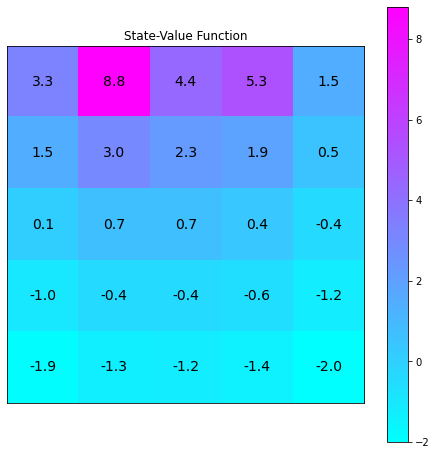

In [ ]:
plot_values(value_o,size=(5,5), name='State')

In [ ]:
new_value = Bellman_equation_RHS(env, agent_uniform, value_o)
iter = 0
while True:
  iter += 1
  if iter > 100:
    break
  new_value = Bellman_equation_RHS(env, agent_uniform, new_value)
plot_values(new_value,size=(5,5), name='State')

Is the variable `new_value` a solution to Bellman's equation? Why, or why not?